# Main Graph Demo

Flow: `question → rewrite → queries → [RAG | Web] → generate`

In [1]:
from lha.config import get_settings

# Clear cache and reload settings
get_settings.cache_clear()
settings = get_settings()

if not settings.tavily_api_key:
    raise ValueError("TAVILY_API_KEY required in .env")

TAVILY_API_KEY: str = settings.tavily_api_key
GOOGLE_API_KEY: str = settings.google_api_key

print(f"LLM model: {settings.llm_model}")
print(f"Rewrite model: {settings.rewrite_model}")
print(f"Embedding model: {settings.embedding_model}")
print("Settings loaded")

LLM model: gemini-2.5-flash-lite
Rewrite model: gemini-2.5-flash-lite
Embedding model: models/gemini-embedding-001
Settings loaded


## 1. Setup

In [2]:
from lha.graphs.main import build_main_graph
from lha.services.llm import create_google_llm
from lha.vectorstore import create_chroma_store, create_google_embeddings

# LLMs
llm = create_google_llm(GOOGLE_API_KEY, model=settings.llm_model)
rewrite_llm = create_google_llm(GOOGLE_API_KEY, model=settings.rewrite_model)

# Vector store - MUST use same embedding model as ChromaDB was created with
embeddings = create_google_embeddings(GOOGLE_API_KEY, model=settings.embedding_model)
vectorstore = create_chroma_store(embeddings, settings.chroma_persist_dir)

# Main graph
graph = build_main_graph(
    vectorstore=vectorstore,
    llm=llm,
    rewrite_llm=rewrite_llm,
    tavily_api_key=TAVILY_API_KEY,
)

print(f"LLM: {settings.llm_model}")
print(f"Rewrite LLM: {settings.rewrite_model}")
print("Main graph ready")

LLM: gemini-2.5-flash-lite
Rewrite LLM: gemini-2.5-flash-lite
Main graph ready


## 2. Graph Visualization

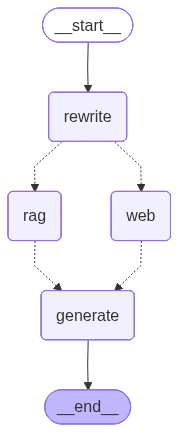

In [3]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 3. Offline Mode (RAG only)

In [4]:
result = await graph.ainvoke(
    {"question": "How do I add memory to a LangGraph agent?"},
    config={"configurable": {"mode": "offline"}},
)

print(f"Queries: {result.get('queries', [])}")
print(f"Docs used: {result['docs_used']}")
print(f"Web results: {result['web_results_used']}")
print(f"\nAnswer:\n{result['answer']}")

# Show sources
print("\n--- Sources ---")
for src in result.get("sources", []):
    icon = "📄" if src["type"] == "doc" else "🌐"
    print(f"{icon} {src['title']} ({src['url']})")

Queries: ['LangGraph agent memory implementation', 'LangGraph add state to agent', 'LangGraph agent memory persistence', 'LangGraph agent state management']
Docs used: 10
Web results: 0

Answer:
You can add memory to a LangGraph agent by leveraging LangGraph's `State`, `Checkpointer`, and `Store` mechanisms.

*   **`State`**: Define a user-defined schema for your memory to specify its exact structure.
*   **`Checkpointer`**: Use this to store the state at each step, enabling memory across different interactions within a session.
*   **`Store`**: This mechanism allows you to persist data across sessions, useful for user-specific or application-level information.

LangChain agents utilize LangGraph persistence for long-term memory. This involves using LangGraph's `memory_store` for persistence.

--- Sources ---
📄 Long-term memory (langchain)
📄 Long-term memory (langchain)
📄 Multi-agent systems (langgraph)
📄 Agent architectures (langgraph)
📄 Multi-agent systems (langgraph)
📄 Build a voice

## 4. Online Mode (Web only)

In [5]:
result = await graph.ainvoke(
    {"question": "What are the latest LangGraph features in 2024?"},
    config={"configurable": {"mode": "online"}},
)

print(f"Queries: {result.get('queries', [])}")
print(f"Docs used: {result['docs_used']}")
print(f"Web results: {result['web_results_used']}")
print(f"\nAnswer:\n{result['answer']}")

# Show sources
print("\n--- Sources ---")
for src in result.get("sources", []):
    icon = "📄" if src["type"] == "doc" else "🌐"
    print(f"{icon} {src['title']}")
    if src["type"] == "web":
        print(f"   {src['url']}")

Queries: ['LangGraph new features 2024', 'LangGraph updates release notes', 'LangGraph advanced capabilities', 'LangGraph state management improvements']
Docs used: 0
Web results: 10

Answer:
Based on the provided search results, here are some of the latest LangGraph features and developments in 2024:

*   **1.0 Alpha Releases:** LangGraph, along with LangChain, hit its 1.0 alpha release in September 2025. This signifies stable interfaces for building production-ready, large-scale agentic applications.
*   **Stateful Runtime:** LangGraph is described as the "stateful runtime under the hood" for LangChain, addressing the challenge of reliably orchestrating long-running, multi-step, tool-using agents.
*   **Durable Execution:** Agents built with LangGraph can pause, resume, and recover across failures, making them more robust for production environments.
*   **Stateful Workflows:** Memory and branching logic are preserved, allowing for more complex and coherent agent interactions.
*   **

## 5. Hybrid Mode (RAG + Web)

In [6]:
result = await graph.ainvoke(
    {"question": "How to implement human-in-the-loop with LangGraph?"},
    config={"configurable": {"mode": "hybrid"}},
)

print(f"Queries: {result.get('queries', [])}")
print(f"Docs used: {result['docs_used']}")
print(f"Web results: {result['web_results_used']}")
print(f"\nAnswer:\n{result['answer']}")

# Show sources (deduplicated)
print("\n--- Sources ---")
seen = set()
for src in result.get("sources", []):
    if src["url"] in seen:
        continue
    seen.add(src["url"])
    icon = "📄" if src["type"] == "doc" else "🌐"
    print(f"{icon} {src['title']}")
    if src["type"] == "web":
        print(f"   {src['url']}")

Queries: ['LangGraph human-in-the-loop implementation', 'LangGraph agent feedback loop', 'LangGraph interactive LLM agents', 'LangGraph user validation workflow']
Docs used: 10
Web results: 10

Answer:
You can implement Human-in-the-Loop (HITL) with LangGraph by integrating human intervention at specific points in your agent's workflow. This allows for validation, correction, or additional context gathering from a human user before the agent proceeds.

Here's how it's generally achieved:

1.  **State Management**: LangGraph uses a shared `State` to keep track of the application's status. This state can be updated by nodes and edges.
2.  **Nodes**: These are functions that perform specific actions. You can create nodes that are designed to pause execution and wait for human input.
3.  **Edges**: These determine the flow between nodes. Conditional edges can be used to route the workflow to a human review node based on certain conditions.
4.  **Persistence and Checkpointing**: LangGraph's